# Stable GAN

In [57]:
import os
import cv2
import math
import numpy as np
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras import backend as K
from keras.layers.core import Activation
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
from keras.utils. generic_utils import Progbar
from matplotlib import pyplot
#from imutils import paths
#from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## GAN models

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 24x24
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # downsample to 12x12
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # downsample to 6x6
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 6x6 image
    n_nodes = 128 * 6 * 6
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 128)))
    # upsample to 12x12
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 24x24
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 48x48
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 48x48x1
    model.add(Conv2D(3, (6,6), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Dataset

In [5]:
def normalize_data(img):
    return (img.astype(np.float32) - 127.5) / 127.5

# load tomato images
def load_real_samples():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/'
    
    trainAug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.05,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest",
            preprocessing_function=normalize_data)
    
    trainGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=64)
    
    return trainGen

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # get batch
    X, _ = dataset.next()
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

## Evaluation of the model

In [11]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap=pyplot.cm.gray)
    # save plot to file
    pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
    pyplot.close()
    # save the generator model
    g_model.save('results_baseline/model_%03d.h5' % (step+1))

In [31]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    #pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    #pyplot.close()
    pyplot.show()

## Training

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for epoch in range(n_epochs):
        print ("Epoch:", epoch)
        n_iter = len(dataset)
        progress_bar = Progbar(target=n_iter)
        for i in range(n_iter):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_model.trainable = True
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            d_model.trainable = False
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            progress_bar.update(i, values=[('d1', d_loss1), ('d2', d_loss2), ('g', g_loss), ('a1', d_acc1), ('a2', d_acc2)])
            # record history
            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
          
        print ('')
        dataset.on_epoch_end()
        summarize_performance(epoch, g_model, latent_dim)

    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

In [20]:
# load image data
dataset = load_real_samples()

Found 191520 images belonging to 240 classes.


In [13]:
# make folder for results
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Epoch: 0
2992/2993 [============================>.] - ETA: 0s - d1: 0.0783 - d2: 0.0746 - g: 1.1329 - a1: 0.9721 - a2: 0.9730
Epoch: 1
2992/2993 [============================>.] - ETA: 0s - d1: 0.0776 - d2: 0.0650 - g: 0.5171 - a1: 0.9738 - a2: 0.9771
Epoch: 2
2992/2993 [============================>.] - ETA: 0s - d1: 0.1085 - d2: 0.0916 - g: 0.7042 - a1: 0.9621 - a2: 0.9663
Epoch: 3
2992/2993 [============================>.] - ETA: 0s - d1: 0.3345 - d2: 0.3310 - g: 1.5838 - a1: 0.8529 - a2: 0.8542
Epoch: 4
2992/2993 [============================>.] - ETA: 0s - d1: 0.4918 - d2: 0.4949 - g: 1.4596 - a1: 0.7542 - a2: 0.7488
Epoch: 5
2992/2993 [============================>.] - ETA: 0s - d1: 0.6449 - d2: 0.6487 - g: 1.1856 - a1: 0.6375 - a2: 0.6311
Epoch: 6
2992/2993 [============================>.] - ETA: 0s - d1: 0.6850 - d2: 0.6899 - g: 1.0394 - a1: 0.5815 - a2: 0.5724
Epoch: 7
2992/2993 [============================>.] - ETA: 0s - d1: 0.6721 - d2: 0.6776 - g: 1.0182 - a1: 0.5899 - a2:

## Results

In [60]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load weights
generator.load_weights('results_baseline/model_020.h5')

In [14]:
### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

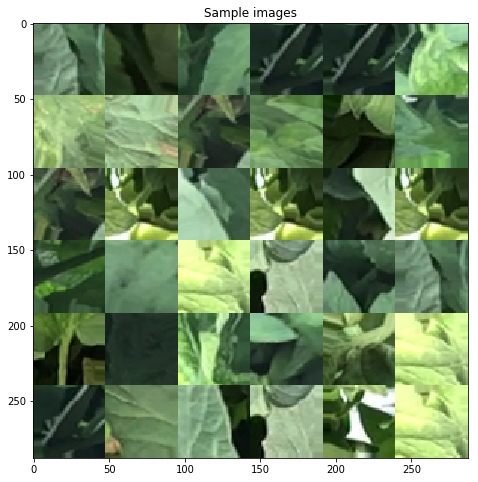

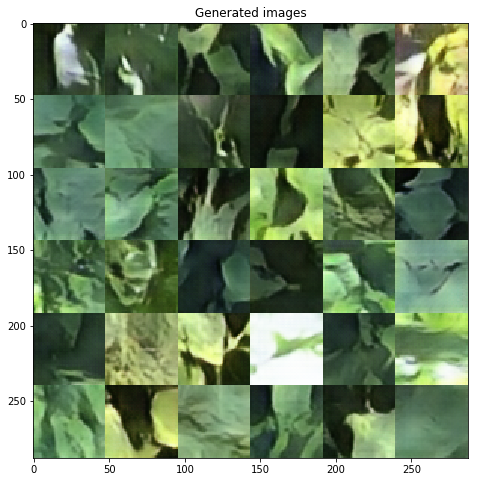

In [30]:
dataset.reset()
img = combine_images(generate_real_samples(dataset, 36)[0])
img = (img*127.5)+127.5
img = img.astype(np.uint8)
dataset.reset()

img2 = combine_images(generate_fake_samples(generator, 100, 36)[0])
img2 = (img2*127.5)+127.5
img2 = img2.astype(np.uint8)

### plt view
pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Sample images')
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.show()

### plt view
pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Generated images')
pyplot.imshow(img2, cmap=pyplot.cm.gray)
pyplot.show()

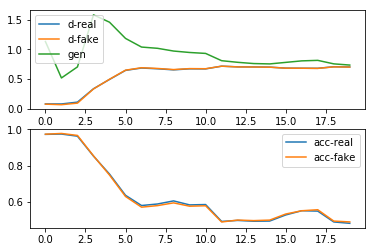

In [32]:
d1_hist = [0.0783, 0.0776, 0.1085, 0.3345, 0.4918, 0.6449, 0.6850, 0.6721, 0.6539, 0.6713, 0.6701, 0.7165, 0.7048, 0.7031, 0.7003, 0.6832, 0.6814, 0.6803, 0.7066, 0.7032]
d2_hist = [0.0746, 0.0650, 0.0916, 0.3310, 0.4949, 0.6487, 0.6899, 0.6776, 0.6590, 0.6751, 0.6731, 0.7161, 0.7038, 0.7021, 0.6991, 0.6826, 0.6815, 0.6788, 0.7044, 0.7011]
g_hist  = [1.1329, 0.5171, 0.7042, 1.5838, 1.4596, 1.1856, 1.0394, 1.0182, 0.9720, 0.9478, 0.9319, 0.8089, 0.7816, 0.7605, 0.7545, 0.7803, 0.8059, 0.8146, 0.7553, 0.7350]
a1_hist = [0.9721, 0.9738, 0.9621, 0.8529, 0.7542, 0.6375, 0.5815, 0.5899, 0.6068, 0.5849, 0.5868, 0.4941, 0.4996, 0.4951, 0.4962, 0.5296, 0.5529, 0.5508, 0.4912, 0.4838]
a2_hist = [0.9730, 0.9771, 0.9663, 0.8542, 0.7488, 0.6311, 0.5724, 0.5810, 0.5960, 0.5777, 0.5801, 0.4911, 0.5016, 0.4986, 0.5014, 0.5348, 0.5527, 0.5583, 0.4960, 0.4915]
plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


## Anomaly detection

In [54]:
### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('weights/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = generator_model()
        g.load_weights('weights/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    #g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(100,))
    gInput = Dense((100), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='adam')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.uniform(0, 1, size=(1, 100))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

In [65]:
### 3. other class anomaly detection

def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 48, 48, 3), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(48,48,3) - similar_img.reshape(48,48,3)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = ((test_img.reshape(48,48,3)*127.5)+127.5).astype(np.uint8)
    similar_x = ((similar_img.reshape(48,48,3)*127.5)+127.5).astype(np.uint8)
    
    #original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

def anomaly_evaluation(test_img, g=None, d=None):
    start = cv2.getTickCount()
    score, qurey, pred, diff = anomaly_detection(test_img, g, d)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    
    ## matplot view
    pyplot.figure(1, figsize=(3, 3))
    pyplot.title('query image')
    pyplot.imshow(qurey.reshape(48,48,3), cmap=pyplot.cm.gray)

    print("anomaly score : ", score)
    print("time : ", time)
    pyplot.figure(2, figsize=(3, 3))
    pyplot.title('generated similar image')
    pyplot.imshow(pred.reshape(48,48,3), cmap=pyplot.cm.gray)
    
    pyplot.figure(3, figsize=(3, 3))
    pyplot.title('anomaly detection')
    pyplot.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
    pyplot.show()

anomaly score :  207.17640686035156
time :  36993.936097000005


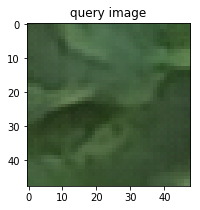

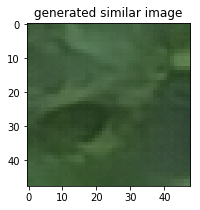

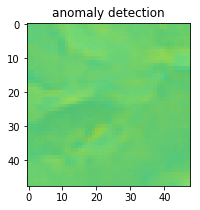

In [68]:
### compute anomaly score - sample from test set
test_img = generate_fake_samples(generator, 100, 36)[0][33]
anomaly_evaluation(np.array([test_img]), generator, discriminator)

anomaly score :  899.9705810546875
time :  36229.758027


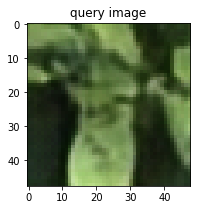

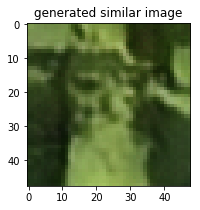

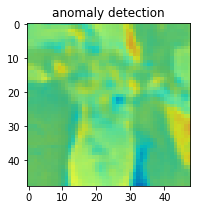

In [67]:
test_img = generate_fake_samples(generator, 100, 36)[0][13]
anomaly_evaluation(np.array([test_img]), generator, discriminator)